In [2]:
import observational_fear.load as load
from observational_fear.nbox_transforms import (
    summarize_prepost_events,
    wilcoxon_by_cell,
)
from observational_fear.events import get_block_starts
from observational_fear.stats import auc
from neurobox.wide_transforms import resample
from pathlib import Path
import pandas as pd
import numpy as np
from binit.align import align_around
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from observational_fear.events import get_freeze_starts
from neurobox.long_transforms import align_to_events
from observational_fear.nbox_transforms import align_to_data_by, exclude_short_trials
from scipy.ndimage import gaussian_filter1d



sns.set_style("whitegrid")


DATA_DIR = Path(r"D:\OFL\one-p experiment\data")
FIG_DIR = Path(r"C:\Users\roryl\repos\observational-fear\figs")


# Day 2

In [3]:
SESSION = "day2"
df_freeze = load.load_freeze(DATA_DIR, session=SESSION)


NameError: name 'SESSION' is not defined

#### CS

In [3]:
block_day2 = pd.read_csv(DATA_DIR / "day2-block-responders.csv")
df = load.load_traces(DATA_DIR, session=SESSION)
df = resample(df.set_index("time"), "100ms")
df = df.reset_index().melt(id_vars=["time"])


c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


#### CS

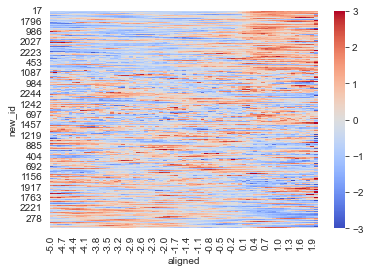

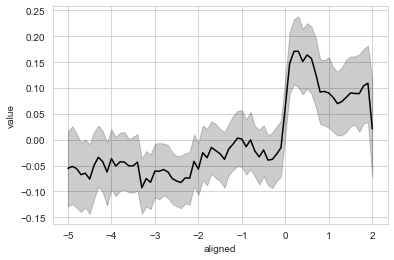

In [4]:
cs_stats = get_block_starts(session="day2", block_name="CS")
idx = (
    block_day2.loc[lambda x: x.block == "CS"]
    .sort_values("diff_of_medians")["new_id"]
    .values.astype(str)
)

dfp = (
    df.copy()
    .assign(
        aligned=lambda x: np.round(
            align_around(x["time"].values, cs_stats, t_before=5, max_latency=2), 2
        )
    )
    .pivot_table(columns="new_id", values="value", index="aligned")
    .apply(zscore)
)[idx]

plt.figure()
sns.heatmap(dfp.transpose(), vmin=-3, vmax=3, cmap="coolwarm")
plt.savefig("Heat CS day2.png", dpi=300)


plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="black",
)
plt.savefig("Line CS day2.svg")




#### US

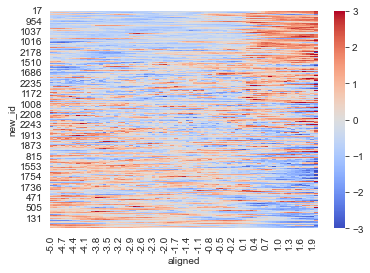

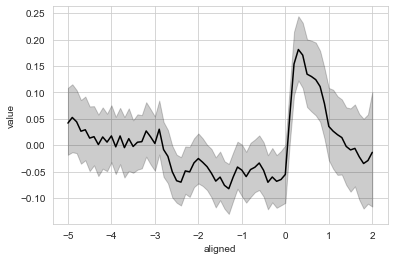

In [5]:
us_stats = get_block_starts(session="day2", block_name="US")
idx = (
    block_day2.loc[lambda x: x.block == "US"]
    .sort_values("diff_of_medians")["new_id"]
    .values.astype(str)
)

dfp = (
    df.copy()
    .assign(
        aligned=lambda x: np.round(
            align_around(x["time"].values, us_stats, t_before=5, max_latency=2), 2
        )
    )
    .pivot_table(columns="new_id", values="value", index="aligned")
    .apply(zscore)
)[idx]

plt.figure()
sns.heatmap(dfp.transpose(), vmin=-3, vmax=3, cmap="coolwarm")
plt.savefig("Heat US day2.png", dpi=300)

plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="black",
)
plt.savefig("Line US day2.svg")



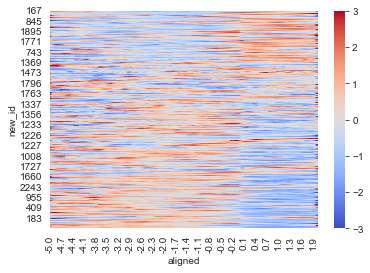

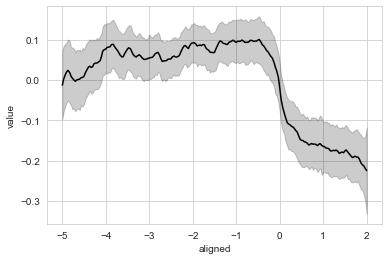

In [8]:
# observer starts

results_day2_freeze_starts = pd.read_csv(DATA_DIR / "freeze_starts_day2.csv")
load.load_freeze(DATA_DIR, SESSION)

events_day2_freeze_starts = get_freeze_starts(
    df_freeze, freeze_col="was_freezing_obs", mouse_col="mouse_name"
)

df_events = events_day2_freeze_starts.rename(columns={"mouse_name": "mouse"})

traces_day2_freeze_starts = align_to_data_by(
    df_data=load.load_cells(DATA_DIR).assign(new_id=lambda x: x.new_id.astype(str)).merge(df).copy(),
    df_events=df_events,
    df_data_time_col="time",
    df_data_cell_col="new_id",
    df_data_value_col="value",
    time_before_event=5,
    time_after_event=2,
    df_data_group_col="mouse",
    df_events_timestamp_col="freeze_start",
    df_events_group_colname="mouse",
    precision=2,
)

traces_day2_freeze_starts = exclude_short_trials(traces_day2_freeze_starts,
                trial_col="event",
                min_bins_pre_event=30,
                min_bins_post_event=15,
                cell_col="new_id")

idx = (
    results_day2_freeze_starts
    .sort_values("diff_of_medians_obs")["new_id"]
    .values.astype(str)
)
dfp = (
    traces_day2_freeze_starts.pivot_table(columns="new_id", values="value", index="aligned")
    .apply(gaussian_filter1d, sigma=1.4)
    .apply(zscore)
)[idx]


plt.figure()
sns.heatmap(dfp.transpose(), vmin=-3, vmax=3, cmap="coolwarm")
plt.savefig("Heat freeze starts observer day2.png", dpi=300)


plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="black",
)
plt.savefig("Line freeze starts observer day2.svg")


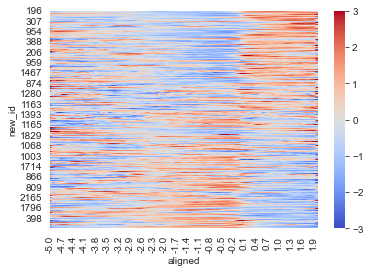

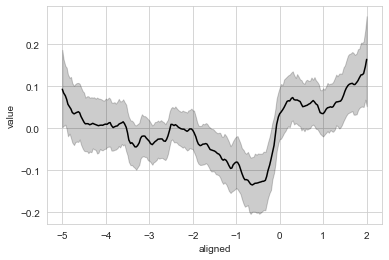

In [9]:
# observer stops
from observational_fear.events import get_freeze_stops

results_day2_freeze_stops = pd.read_csv(DATA_DIR / "freeze_stops_day2.csv")
load.load_freeze(DATA_DIR, SESSION)

events_day2_freeze_stops = get_freeze_stops(
    df_freeze, freeze_col="was_freezing_obs", mouse_col="mouse_name"
)

df_events = events_day2_freeze_stops.rename(columns={"mouse_name": "mouse"})

traces_day2_freeze_stops = align_to_data_by(
    df_data=load.load_cells(DATA_DIR).assign(new_id=lambda x: x.new_id.astype(str)).merge(df).copy(),
    df_events=df_events,
    df_data_time_col="time",
    df_data_cell_col="new_id",
    df_data_value_col="value",
    time_before_event=5,
    time_after_event=2,
    df_data_group_col="mouse",
    df_events_timestamp_col="freeze_stop",
    df_events_group_colname="mouse",
    precision=2,
)
traces_day2_freeze_stops = exclude_short_trials(traces_day2_freeze_stops,
                trial_col="event",
                min_bins_pre_event=30,
                min_bins_post_event=15,
                cell_col="new_id")

idx = (
    results_day2_freeze_stops
    .sort_values("diff_of_medians_obs")["new_id"]
    .values.astype(str)
)

dfp = (
    traces_day2_freeze_stops.pivot_table(columns="new_id", values="value", index="aligned")
    .apply(gaussian_filter1d, sigma=1.4)
    .apply(zscore)
)[idx]


plt.figure()
sns.heatmap(dfp.transpose(), vmin=-3, vmax=3, cmap="coolwarm")
plt.savefig("Heat freeze stops observer day2.png", dpi=300)

plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="black",
)
plt.savefig("Line freeze stops observer day2.svg")


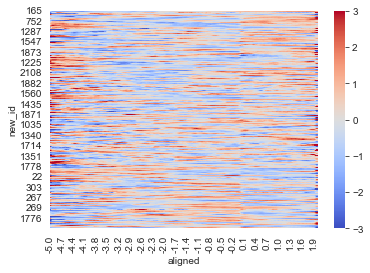

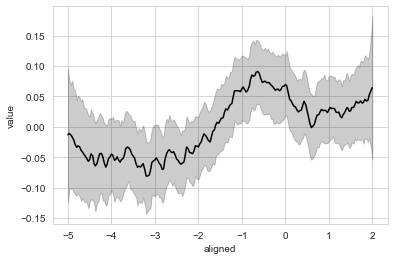

In [10]:
# dem starts

results_day2_freeze_starts = pd.read_csv(DATA_DIR / "freeze_starts_day2.csv")
load.load_freeze(DATA_DIR, SESSION)

events_day2_freeze_starts = get_freeze_starts(
    df_freeze, freeze_col="was_freezing_dem", mouse_col="mouse_name"
)

df_events = events_day2_freeze_starts.rename(columns={"mouse_name": "mouse"})

traces_day2_freeze_starts = align_to_data_by(
    df_data=load.load_cells(DATA_DIR).assign(new_id=lambda x: x.new_id.astype(str)).merge(df).copy(),
    df_events=df_events,
    df_data_time_col="time",
    df_data_cell_col="new_id",
    df_data_value_col="value",
    time_before_event=5,
    time_after_event=2,
    df_data_group_col="mouse",
    df_events_timestamp_col="freeze_start",
    df_events_group_colname="mouse",
    precision=2,
)
traces_day2_freeze_starts = exclude_short_trials(traces_day2_freeze_starts,
                trial_col="event",
                min_bins_pre_event=30,
                min_bins_post_event=15,
                cell_col="new_id")

idx = (
    results_day2_freeze_starts
    .sort_values("diff_of_medians_dem")["new_id"]
    .values.astype(str)
)

dfp = (
    traces_day2_freeze_starts.pivot_table(columns="new_id", values="value", index="aligned")
    .apply(gaussian_filter1d, sigma=1.4)
    .apply(zscore)
)[idx]


plt.figure()
sns.heatmap(dfp.transpose(), vmin=-3, vmax=3, cmap="coolwarm")
plt.savefig("Heat freeze starts demonstrator day2.png", dpi=300)

plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="black",
)
plt.savefig("Line freeze starts demonstrator day2.svg")


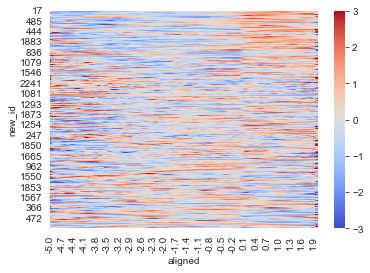

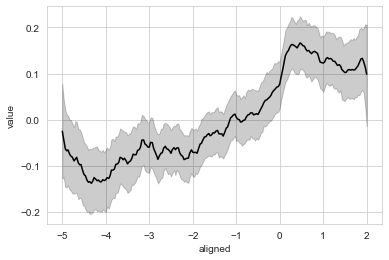

In [11]:
results_day2_freeze_stops = pd.read_csv(DATA_DIR / "freeze_stops_day2.csv")
load.load_freeze(DATA_DIR, SESSION)

events_day2_freeze_stops = get_freeze_stops(
    df_freeze, freeze_col="was_freezing_dem", mouse_col="mouse_name"
)

df_events = events_day2_freeze_stops.rename(columns={"mouse_name": "mouse"})

traces_day2_freeze_stops = align_to_data_by(
    df_data=load.load_cells(DATA_DIR).assign(new_id=lambda x: x.new_id.astype(str)).merge(df).copy(),
    df_events=df_events,
    df_data_time_col="time",
    df_data_cell_col="new_id",
    df_data_value_col="value",
    time_before_event=5,
    time_after_event=2,
    df_data_group_col="mouse",
    df_events_timestamp_col="freeze_stop",
    df_events_group_colname="mouse",
    precision=2,
)
traces_day2_freeze_stops = exclude_short_trials(traces_day2_freeze_stops,
                trial_col="event",
                min_bins_pre_event=30,
                min_bins_post_event=15,
                cell_col="new_id")

idx = (
    results_day2_freeze_stops
    .sort_values("diff_of_medians_dem")["new_id"]
    .values.astype(str)
)

dfp = (
    traces_day2_freeze_stops.pivot_table(columns="new_id", values="value", index="aligned")
    .apply(gaussian_filter1d, sigma=1.4)
    .apply(zscore)
)[idx]


plt.figure()
sns.heatmap(dfp.transpose(), vmin=-3, vmax=3, cmap="coolwarm")
plt.savefig("Heat freeze stops demonstrator.svg")

plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="black",
)
plt.savefig("Line freeze stops demonstrator day2.svg")

# Day 4

In [4]:
SESSION = "day4"
df_freeze = load.load_freeze(DATA_DIR, session=SESSION)

In [5]:
block_day4 = pd.read_csv(DATA_DIR / "day4-block-responders.csv")
df = load.load_traces(DATA_DIR, session=SESSION)
df = resample(df.set_index("time"), "100ms")
df = df.reset_index().melt(id_vars=["time"])


c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


In [10]:
block_day4
block_day2 = pd.read_csv(DATA_DIR / "day2-block-responders.csv")
block_day4_d2cells = block_day2.merge(block_day4[["new_id"]])

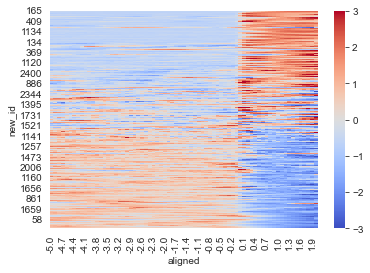

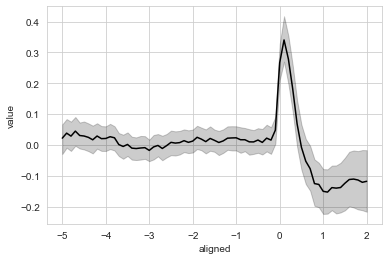

In [28]:
us_stats = get_block_starts(session="day4", block_name="US")
idx = (
    block_day4.loc[lambda x: x.block == "US"]
    .sort_values("diff_of_medians")["new_id"]
    .values.astype(str)
)

dfp = (
    df.copy()
    .assign(
        aligned=lambda x: np.round(
            align_around(x["time"].values, us_stats, t_before=5, max_latency=2), 2
        )
    )
    .pivot_table(columns="new_id", values="value", index="aligned")
    .apply(zscore)
)[idx]

plt.figure()
sns.heatmap(dfp.transpose(), vmin=-3, vmax=3, cmap="coolwarm")
plt.savefig("Heat US day4.png", dpi=300)

plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="black",
)
plt.savefig("Line US day4.svg")



In [43]:
events_day4_freeze_starts = get_freeze_starts(
    df_freeze, freeze_col="was_freezing", mouse_col="mouse_name"
)
events_day4_freeze_starts

,mouse_name,freeze_start
0,B17274,0.166667
1,B17274,2.033333
2,B17274,2.766667
3,B17274,5.500000
4,B17274,6.366667
...,...,...
1555,PL-OFL-7,2107.000000
1556,PL-OFL-7,2113.333333
1557,PL-OFL-7,2133.533333
1558,PL-OFL-7,2148.200000


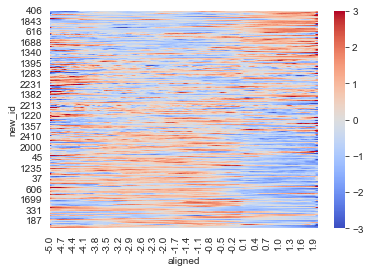

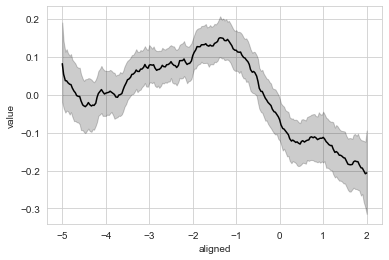

In [46]:
# dem starts

results_day4_freeze_starts = pd.read_csv(DATA_DIR / "freeze_starts_day4.csv")
df_freeze = load.load_behaviour(DATA_DIR, session=SESSION)

events_day4_freeze_starts = get_freeze_starts(
    df_freeze, freeze_col="was_freezing", mouse_col="mouse_name"
).rename(columns={"mouse_name": "mouse"})

traces_day4_freeze_starts = align_to_data_by(
    df_data=load.load_cells(DATA_DIR).assign(new_id=lambda x: x.new_id.astype(str)).merge(df).copy(),
    df_events=events_day4_freeze_starts,
    df_data_time_col="time",
    df_data_cell_col="new_id",
    df_data_value_col="value",
    time_before_event=5,
    time_after_event=2,
    df_data_group_col="mouse",
    df_events_timestamp_col="freeze_start",
    df_events_group_colname="mouse",
    precision=2,
)
traces_day4_freeze_starts = exclude_short_trials(traces_day4_freeze_starts,
                trial_col="event",
                min_bins_pre_event=30,
                min_bins_post_event=15,
                cell_col="new_id")

idx = (
    results_day4_freeze_starts
    .sort_values("diff_of_medians")["new_id"]
    .values.astype(str)
)

dfp = (
    traces_day4_freeze_starts.pivot_table(columns="new_id", values="value", index="aligned")
    .apply(gaussian_filter1d, sigma=1.4)
    .apply(zscore)
)[idx]


plt.figure()
sns.heatmap(dfp.transpose(), vmin=-3, vmax=3, cmap="coolwarm")
plt.savefig("Heat freeze starts day4.png", dpi=300)

plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="black",
)
plt.savefig("Line freeze starts  day4.svg")


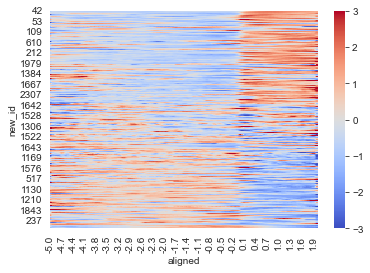

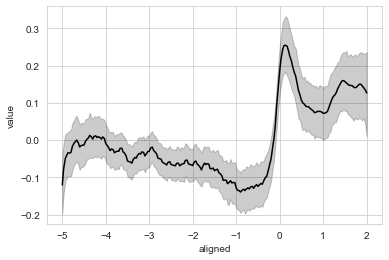

In [47]:
# dem starts

results_day4_freeze_stops = pd.read_csv(DATA_DIR / "freeze_stops_day4.csv")
df_freeze = load.load_behaviour(DATA_DIR, session=SESSION)

events_day4_freeze_stops = get_freeze_stops(
    df_freeze, freeze_col="was_freezing", mouse_col="mouse_name"
).rename(columns={"mouse_name": "mouse"})

traces_day4_freeze_stops = align_to_data_by(
    df_data=load.load_cells(DATA_DIR).assign(new_id=lambda x: x.new_id.astype(str)).merge(df).copy(),
    df_events=events_day4_freeze_stops,
    df_data_time_col="time",
    df_data_cell_col="new_id",
    df_data_value_col="value",
    time_before_event=5,
    time_after_event=2,
    df_data_group_col="mouse",
    df_events_timestamp_col="freeze_stop",
    df_events_group_colname="mouse",
    precision=2,
)
traces_day4_freeze_stops = exclude_short_trials(traces_day4_freeze_stops,
                trial_col="event",
                min_bins_pre_event=30,
                min_bins_post_event=15,
                cell_col="new_id")

idx = (
    results_day4_freeze_stops
    .sort_values("diff_of_medians")["new_id"]
    .values.astype(str)
)

dfp = (
    traces_day4_freeze_stops.pivot_table(columns="new_id", values="value", index="aligned")
    .apply(gaussian_filter1d, sigma=1.4)
    .apply(zscore)
)[idx]


plt.figure()
sns.heatmap(dfp.transpose(), vmin=-3, vmax=3, cmap="coolwarm")
plt.savefig("Heat freeze stops day4.png", dpi=300)

plt.figure()
sns.lineplot(
    data=dfp.reset_index().melt(id_vars="aligned"),
    x="aligned",
    y="value",
    color="black",
)
plt.savefig("Line freeze stops day4.svg")
